# Identifying Particles

Import necessary python libraries

In [1]:
%matplotlib inline
import sys
sys.path.append("..") # Adds the module to path

In [2]:
import deeptrack as dt
import keras
import matplotlib.pyplot as plt
from matplotlib import image
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import time

# Set seeds
random.seed(14)
np.random.seed(0)

print("Import Complete")

Import Complete


## Plot one Sample Image and it's Label

In [3]:
# # Load in single image
# img_data = image.imread('/Users/zhimin/Courtney/winter_research/data/dataset/image1.jpg')

# # Convert to DeepTrack 2.0 Feature
# img_data = dt.features.Dataset(img_data)
# output_image = img_data.resolve()

# # Display image
# plt.imshow(output_image)

# # Load in Labels
# dataset = pd.read_csv('/Users/zhimin/Courtney/winter_research/data/csv/data.csv')
# dataset = np.array(dataset)

# dataset = dataset / 2.0 - 1
# print(dataset[:, 0:5])

# label = dataset[0]
# print(label)

# # Plot single image against label position
# plt.imshow(np.squeeze(output_image), cmap='gray')
# plt.scatter(label[1], label[0], c="r", marker="x") # 1-indexed, compensate with -1
# plt.show()

## Plot Multiple Sample Images and it's Labels

In [4]:
# # ==========================================
# # Load in all images
# all_images = []
# for i in range(0, NUM_OF_IMAGES):
#     image_name = 'image' + str(i + 1) + '.jpg'
#     img_data = image.imread('/Users/zhimin/Courtney/winter_research/data/dataset/' + image_name)
#     all_images.append(img_data)

# print("Finished loading all images")

# img_data = all_images[0]
# img_data = dt.features.Dataset(img_data)
# output_image = img_data.resolve()
# plt.imshow(np.squeeze(output_image), cmap='gray')

# # Load in Labels
# dataset = pd.read_csv('/Users/zhimin/Courtney/winter_research/data/csv/data.csv')
# dataset = np.array(dataset, dtype="float64")
# dataset = dataset / 2.0 - 1 # div 2 for fractional units, -1 to offset MATLAB 1-index

# # ==========================================
# # Sample a few points to show the true label
# chosen = [0, 6, 266, 977]
# for i in chosen:
#     # Select image plot
#     img_data = all_images[i]
#     img_data = dt.features.Dataset(img_data)
#     output_image = img_data.resolve()
    
#     # Display image grayscale
#     plt.imshow(np.squeeze(output_image), cmap='gray')
    
#     # Load in label for selected data
#     label = dataset[i]
#     print(label)

#     # Show image with true label
# #     plt.imshow(np.squeeze(output_image), cmap='gray')
# #     plt.scatter(label[1], label[0], c="r", marker="x") # 1-indexed, compensate with -1
# #     plt.show()
# original_all_images = all_images.copy()



## Loading in Images
Graph images, verify that the gold-standard center is accurate enough

# Defining Constants  

### Input Relevant Constants  
`NUM_OF_IMAGES`: Total number of images to load in  
`MAX_WIDTH`: Dimension of the final image to be used *after* displacing the particle  
`FRACTIONAL_UNIT`: Same value as the changed parameter in MATLAB (not the exact fractional unit). In MATLAB, the fractional unit is $2^X$, where $X$ is the value changed. 

### Model Training Relevant Constants  
`TEST_SIZE`: The fraction of data to be used for testing (value between 0.0 to 1.0)  
`SHUFFLE_ON`: Whether to shuffle the training/testing set  
`NUM_EPOCHS`: The number of training epochs  

### Model Testing Relevant Constants  
`COORD_EPSILON`: The acceptable difference between predicted and actual values to be considered 'accurate'  

In [5]:
# Input
NUM_OF_IMAGES = 1000
MAX_WIDTH     = 101
FRACTIONAL_UNIT = 1 # corresponds to the fractional unit in MATLAB (X in 2^X)
SIZE_OF_PARTICLE = 22 # 22 by 22 area in the center of the image.

# Model Training
TEST_SIZE     = 0.2
SHUFFLE_ON    = True # shuffle training/testing set
NUM_EPOCHS    = 200

# Model Testing
COORD_EPSILON = 1.0   # acceptable difference to be considered 'accurate'

(1000, 101, 101)


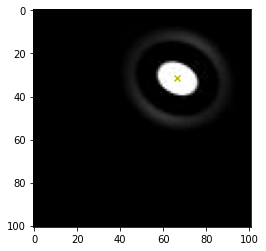

In [6]:
# # Load in all images
all_images = []
for i in range(0, NUM_OF_IMAGES):
    image_name = 'image' + str(i + 1) + '.jpg'
    img_data = image.imread('/Users/zhimin/Courtney/winter_research/data/dataset/' + image_name)
    all_images.append(img_data)
original_all_images = all_images.copy()

# Load in Labels
dataset = pd.read_csv('/Users/zhimin/Courtney/winter_research/data/csv/data.csv')
# dataset = pd.read_csv('/Users/zhimin/Courtney/winter_research/data/7-Jul-unsuppressed/csv/data.csv')

dataset = np.array(dataset, dtype="float64")
dataset = dataset / (2.0**FRACTIONAL_UNIT) - 1


new_all_images = []

# Load in images and displace them. Update labels accordingly.
for i in range(1, NUM_OF_IMAGES + 1):
    img_data = image.imread('/Users/zhimin/Courtney/winter_research/data/dataset/image' + str(i) + '.jpg')
#     img_data = image.imread('/Users/zhimin/Courtney/winter_research/data/7-Jul-unsuppressed/dataset/rimage' + str(i) + '.jpg')

    particle_only = img_data[SIZE_OF_PARTICLE:-1 * SIZE_OF_PARTICLE, SIZE_OF_PARTICLE:-1 * SIZE_OF_PARTICLE]
    offset = 2 * SIZE_OF_PARTICLE
    
    rand_x = random.randint(0, 2 * SIZE_OF_PARTICLE)
    rand_y = random.randint(0, 2 * SIZE_OF_PARTICLE)
    
    displaced = np.pad(particle_only, ((rand_x, offset - rand_x), (rand_y, offset - rand_y)), 'constant')
    
    # Add new images and labels
    new_all_images.append(displaced)
    
    new_x = dataset[i - 1][0] - SIZE_OF_PARTICLE + rand_x
    new_y = dataset[i - 1][1] - SIZE_OF_PARTICLE + rand_y
    dataset[i - 1] = [new_x, new_y, dataset[i - 1][2]]
    
new_all_images = np.array(new_all_images)
print(new_all_images.shape)
# print(new_all_images.shape)
plt.imshow(np.squeeze(new_all_images[0]), cmap='gray')
label = dataset[0]
plt.scatter(label[1], label[0], c="y", marker="x") # 1-indexed, compensate with -1
plt.show()

## Training NN
It seems like the labels can only be a single value, so the way it is currently working on it, is to have a separate CNN for x- and y- labels. When combined, they will give the center position attribute for the cell.

In [7]:

X_train, X_test, Y_train, Y_test = train_test_split(new_all_images, dataset, test_size=TEST_SIZE, shuffle=SHUFFLE_ON)

# Labels into individual sets.
train_x_labels     = np.zeros(800)
train_y_labels     = np.zeros(800)
train_angle_labels = np.zeros(800)

test_x_labels     = np.zeros(200)
test_y_labels     = np.zeros(200)
test_angle_labels = np.zeros(200)


# Split by x, y coordinates
count = 0
for elem in Y_train:
    train_x_labels[count] = elem[0]
    train_y_labels[count] = elem[1]
    train_angle_labels[count] = elem[2]
    count += 1

count = 0
for elem in Y_test:
    test_x_labels[count] = elem[0]
    test_y_labels[count] = elem[1]
    test_angle_labels[count] = elem[2]
    count += 1

# X_train, X_test, Y_x_train, Y_x_test = train_test_split(new_all_images, x_dataset, shuffle=False)

# # Data
all_images = tf.convert_to_tensor(new_all_images)
train_images = tf.convert_to_tensor(X_train)


# # x-coordinate position labels
# x_dataset = tf.convert_to_tensor(x_dataset)
# train_x_labels = tf.convert_to_tensor(train_x_labels)

In [8]:
def accuracy_prediction(model, train_images, test_images, train_labels, test_labels, train_acc=True, epsilon=COORD_EPSILON):
    if train_acc:
        predicted = np.array(model.predict_on_batch(train_images))
        train_labels = tf.convert_to_tensor(train_labels)

        count = 0
        for i in range(0, len(train_labels)):
            difference = round(round(predicted[i][0], 1) - float(train_labels[i]), 2)
            if abs(difference) <= epsilon:
                count += 1

        print("Training Accuracy: ", count / len(train_labels) * 100, "%")

    # 357 correct within 0.5
    # 613 correct within 1.0

    # ========
    test_images = tf.convert_to_tensor(X_test)
    test_labels = tf.convert_to_tensor(test_labels)

    predicted = np.array(model.predict_on_batch(test_images))
    
    count = 0
    for i in range(0, len(test_labels)):
        difference = round(round(predicted[i][0], 1) - float(test_labels[i]), 2)
        if abs(difference) <= epsilon:
            count += 1
    test_accuracy_percent = count / len(test_labels) * 100
    print("Test Accuracy", test_accuracy_percent, "%")
    return test_accuracy_percent

In [9]:
# x_model = dt.models.convolutional(
#     input_shape=(MAX_WIDTH, MAX_WIDTH, 1), 
#       conv_layers_dimensions=(1,),
#       dense_top=False,
#     activation_function="relu", # flatten it too (? maybe use standard keras here)
#     number_of_outputs=1,
#     loss='mean_absolute_error',
#     optimiser='adam',
#     metrics=['mean_squared_error'],
#     output_activation="linear",
# )

# print("Model summary:")
# x_model.summary()

# y_model = dt.models.convolutional(
#     input_shape=(MAX_WIDTH, MAX_WIDTH, 1), 
#       conv_layers_dimensions=(1,),
#       dense_top=False,
#     activation_function="relu", # flatten it too (? maybe use standard keras here)
#     number_of_outputs=1,
#     loss='mean_absolute_error',
#     optimiser='adam',
#     metrics=['mean_squared_error'],
#     output_activation="linear",
# )

# print("Model summary:")
# y_model.summary()

angle_model = dt.models.convolutional(
    input_shape=(MAX_WIDTH, MAX_WIDTH, 1), 
    conv_layers_dimensions=(1,),
#     dense_top=False,
    activation_function="relu", # flatten it too (? maybe use standard keras here)
    number_of_outputs=1,
    loss='mean_absolute_error',
    optimiser='adam',
    metrics=['mean_squared_error'],
    output_activation="linear",
)

print("Model summary:")
angle_model.summary()

Model summary:
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 101, 101, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 101, 101, 1)       10        
_________________________________________________________________
activation (Activation)      (None, 101, 101, 1)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 51, 51, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2601)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                83264     
_________________________________________________________________
activation_1 (Activation)    (None, 32)       

In [10]:
NUM_EPOCHS = 500

In [11]:
def train_x(x_model):
    print("Fitting the model")
    start = time.time()
    x_history = x_model.fit(
        x=train_images,
        y=train_x_labels,
        epochs=NUM_EPOCHS,
        validation_split=0.4,
        verbose=0,
    )
    print("Model finished fitting. Took ", time.time() - start, "seconds")

In [12]:
def train_y(y_model):
    print("Fitting the model")
    start = time.time()
    y_history = y_model.fit(
        x=train_images,
        y=train_y_labels,
        epochs=NUM_EPOCHS,
        validation_split=0.4,
        verbose=0,
    )

    print("Model finished fitting. Took ", time.time() - start, "seconds")

In [13]:
def train_angle(angle_model):
    print("Fitting the model")
    start = time.time()
    angle_history = angle_model.fit(
        x=train_images,
        y=train_angle_labels,
        epochs=50,
        validation_split=0.4,
        verbose=0,
    )

    print("Model finished fitting. Took ", time.time() - start, "seconds")
    return angle_history

In [14]:
# train_x(x_model)
# print("X-Coordinate")
# accuracy_prediction(x_model, X_train, X_test, train_x_labels, test_x_labels)


# # TODO consider majority voting ?

In [15]:
# train_y(y_model)
# print("Y-Coordinate")
# test_acc = accuracy_prediction(y_model, X_train, X_test, train_y_labels, test_y_labels)

In [16]:
angle_history = train_angle(angle_model)
print("Angle")

test_acc = accuracy_prediction(angle_model, X_train, X_test, train_angle_labels, test_angle_labels, epsilon=0.2)

Fitting the model
Model finished fitting. Took  20.211201906204224 seconds
Angle
Training Accuracy:  80.125 %
Test Accuracy 56.99999999999999 %


In [17]:
test_acc = accuracy_prediction(angle_model, X_train, X_test, train_angle_labels, test_angle_labels, epsilon=0.2)

Training Accuracy:  80.125 %
Test Accuracy 56.99999999999999 %


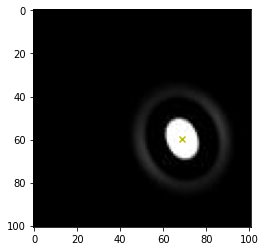

Actual -0.80629
Predicted [-0.39177504]


In [18]:
index = 656

plt.imshow(np.squeeze(X_train[index]), cmap='gray')
plt.scatter(train_y_labels[index], train_x_labels[index], c="y", marker="x") # 1-indexed, compensate with -1
# x_predicted = np.array(x_model.predict_on_batch(train_images))
# y_predicted = np.array(y_model.predict_on_batch(train_images))
# plt.scatter(x_predicted[index], y_predicted[index], c="r", marker="x") # 1-indexed, compensate with -1
plt.show()

predicted = np.array(angle_model.predict_on_batch(X_train))


print("Actual", train_angle_labels[index])
print("Predicted", predicted[index])


91.0 104.0


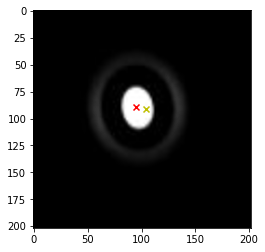

90.88888888888889 78.22222222222223


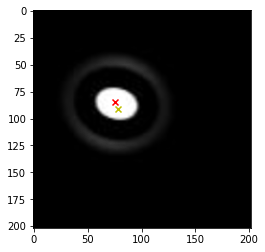

133.0 130.66666666666666


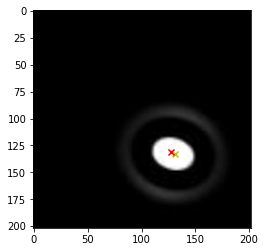

145.0 133.0


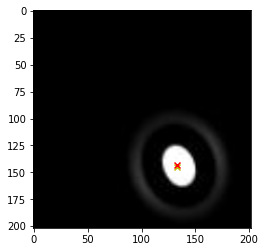

77.5 71.125


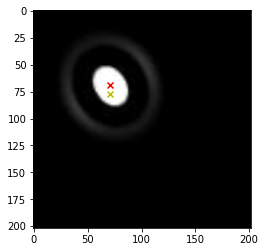

68.33333333333333 93.0


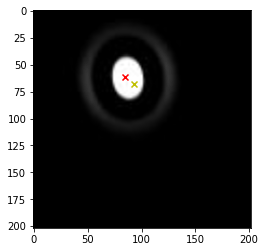

129.5 143.0


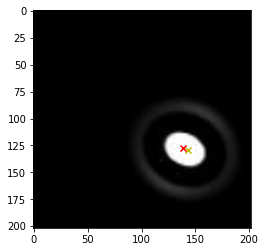

64.0 109.0


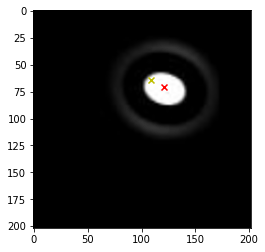

106.17647058823529 80.94117647058823


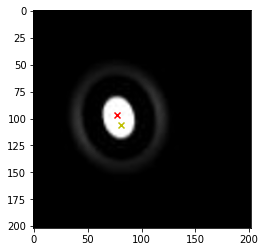

60.0 97.0


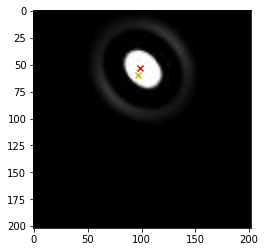

130.4390243902439 70.5609756097561


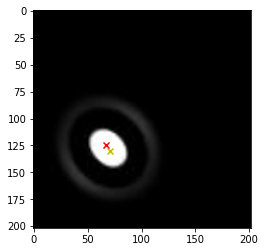

73.82352941176471 61.35294117647059


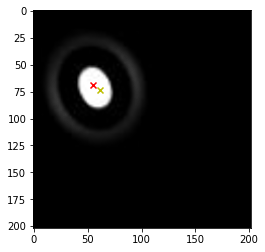

115.33333333333333 123.33333333333333


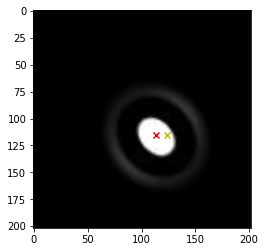

109.0 67.5


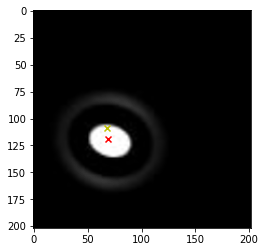

128.0 129.0


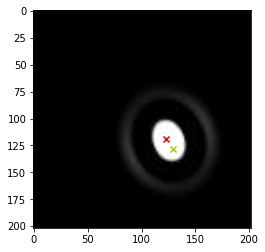

124.66666666666667 93.0


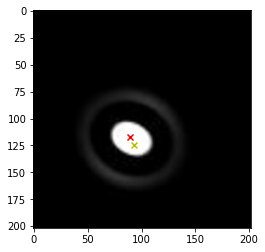

116.0 91.0


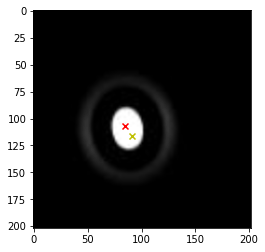

116.16666666666667 127.16666666666667


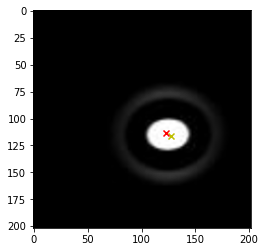

82.0 123.0


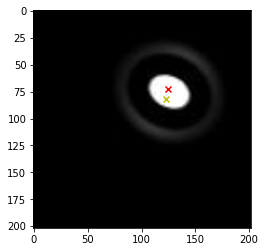

80.0 70.0


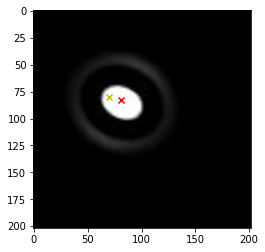

132.0 91.0


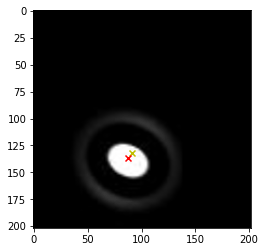

144.625 64.625


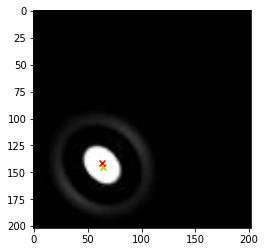

123.66666666666667 143.33333333333334


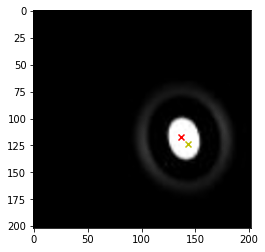

71.5 94.0


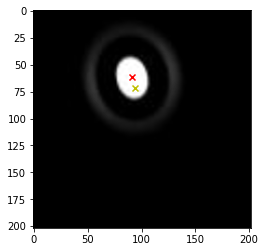

80.0 91.0


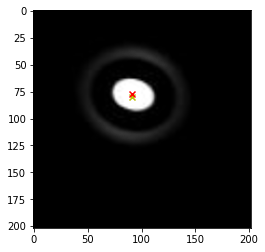

116.0 60.0


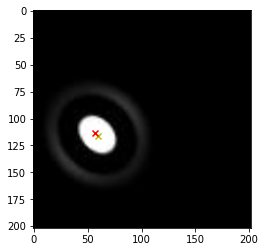

127.22 108.82


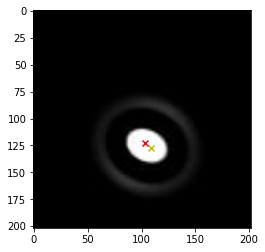

109.0 113.125


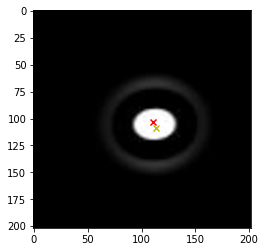

82.27777777777777 62.44444444444444


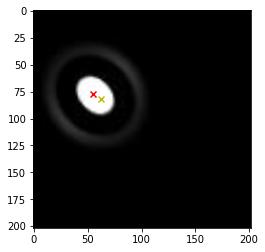

136.07692307692307 138.07692307692307


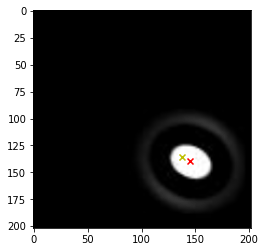

139.66666666666666 98.5


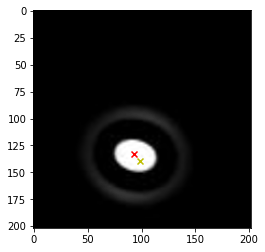

70.0 109.0


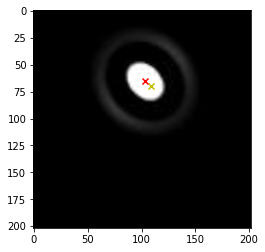

128.0 129.0


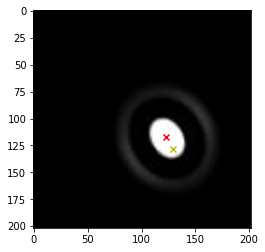

70.0 109.0


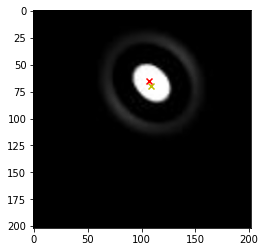

91.0 93.5


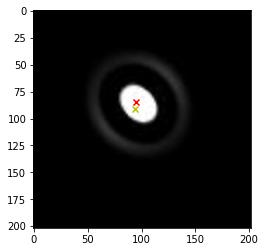

128.0 129.0


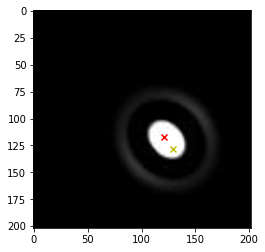

95.3 73.43333333333334


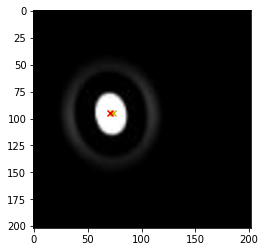

133.0 61.0


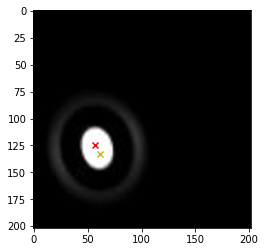

89.89285714285714 85.42857142857143


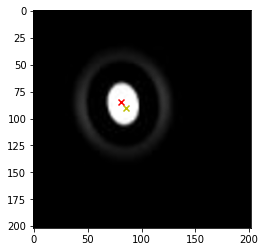

80.0 91.0


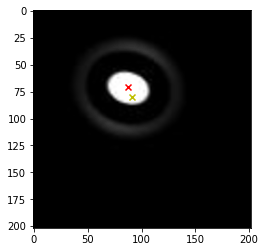

93.5 88.5


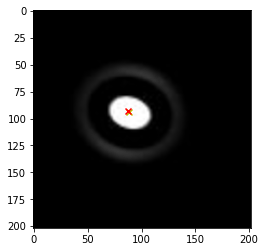

128.0 91.0


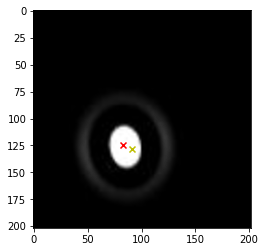

81.0 143.0


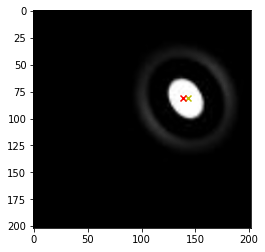

119.0 60.0


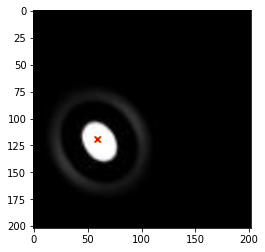

93.0 91.0


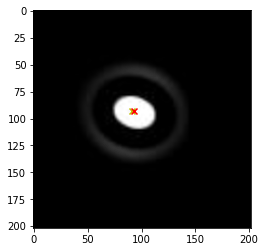

60.0 94.0


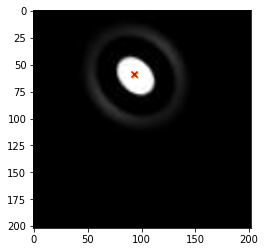

83.8 123.0


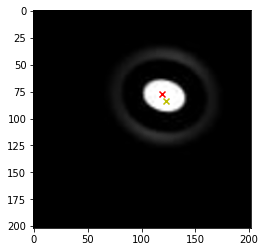

60.0 94.0


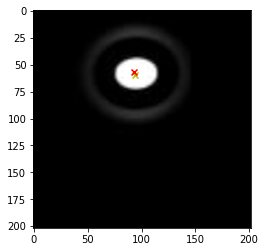

85.75 148.25


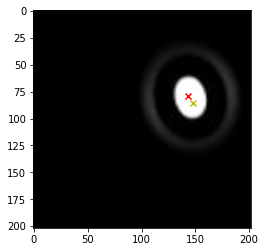

143.0 109.0


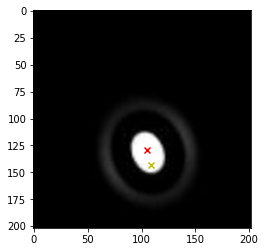

113.0 143.0


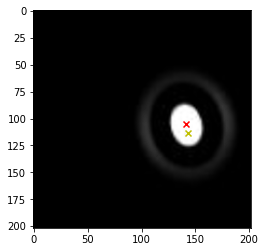

128.0 91.0


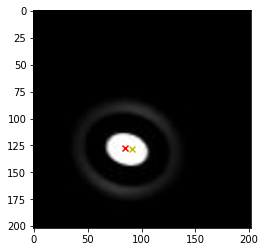

80.5 143.0


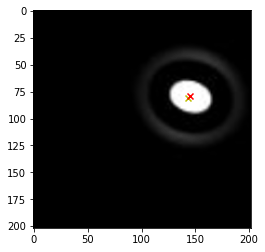

80.0 87.0


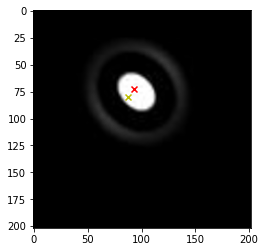

142.5 148.0


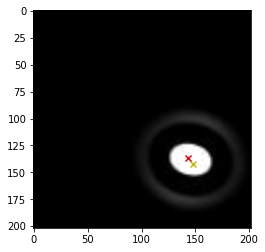

128.0 129.0


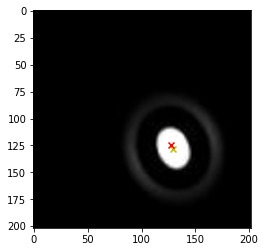

91.0 133.0


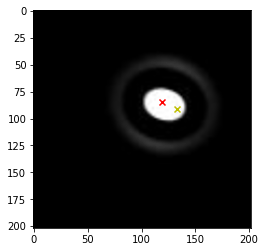

126.375 115.125


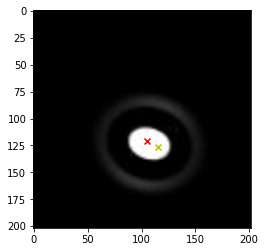

140.17948717948718 79.33333333333333


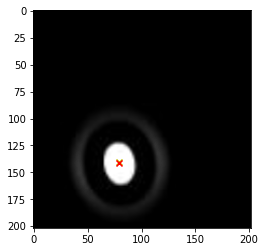

92.89473684210526 76.3157894736842


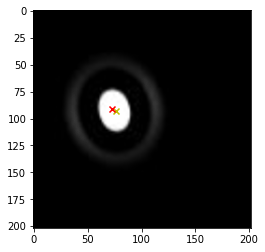

79.24242424242425 116.12121212121212


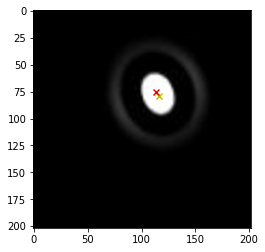

76.125 70.375


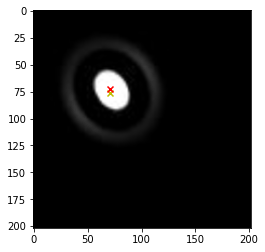

80.0 91.0


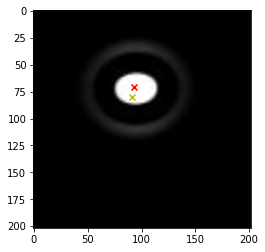

87.25 72.0


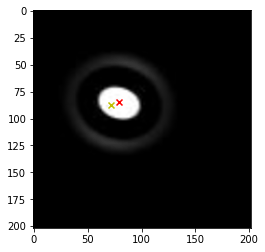

80.0 91.0


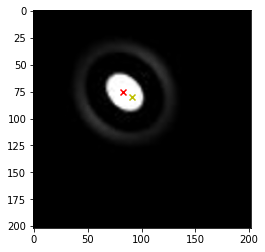

107.0 91.0


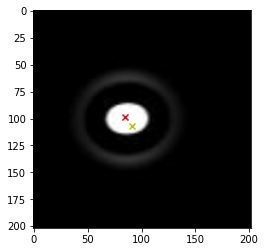

60.0 94.0


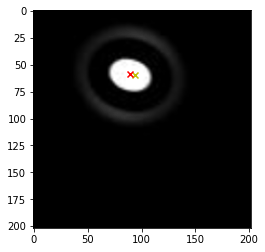

76.0 119.0


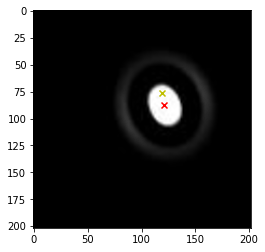

93.8695652173913 85.21739130434783


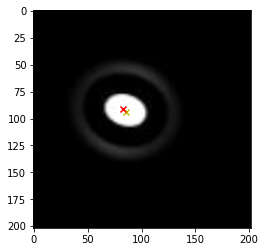

70.0 133.0


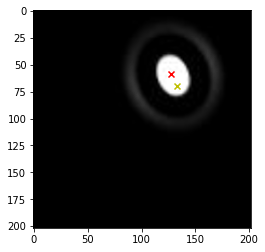

91.0 112.0


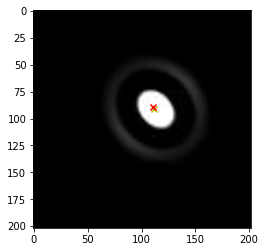

80.5 143.0


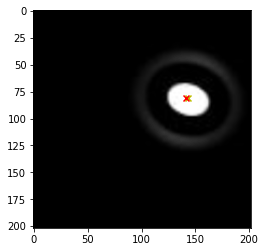

113.0 83.28125


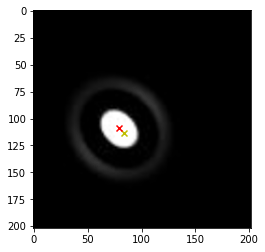

129.42857142857142 147.28571428571428


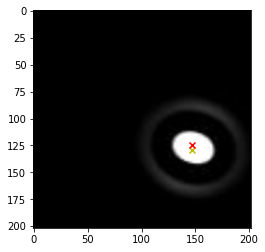

119.0 60.0


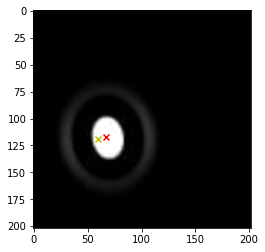

135.66666666666666 125.16666666666667


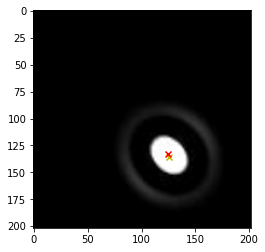

113.0 104.0


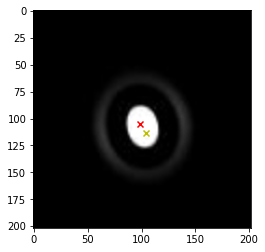

91.0 106.5


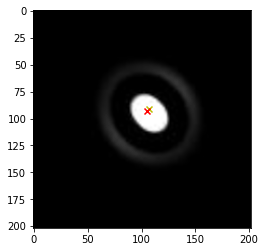

67.0 123.0


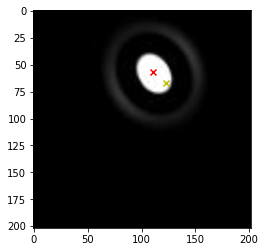

84.47368421052632 60.63157894736842


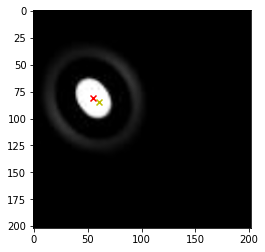

91.33333333333333 64.0


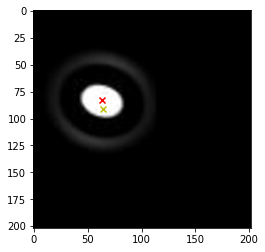

67.0 123.0


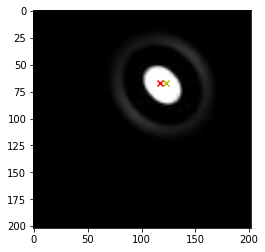

143.5 116.0


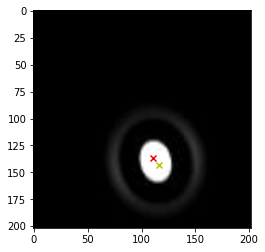

133.0 91.0


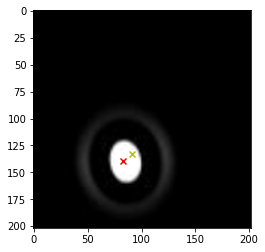

84.03703703703704 62.407407407407405


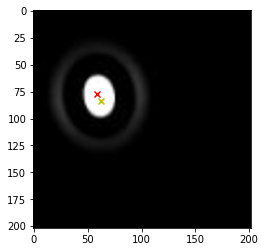

81.8 63.8


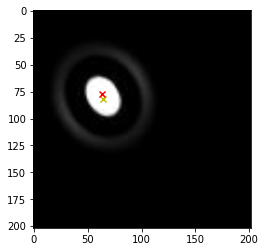

58.0 65.5


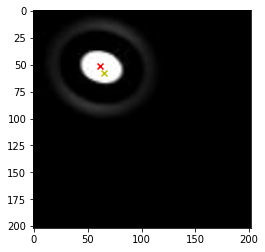

119.25 118.6875


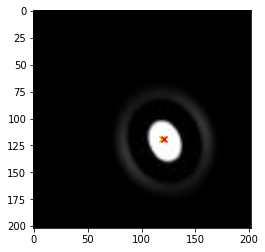

104.0 91.0


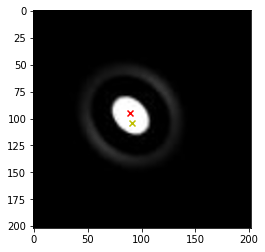

109.5 136.0


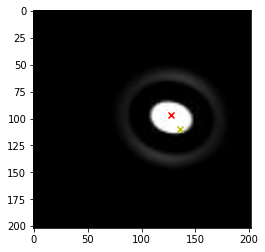

62.37931034482759 133.44827586206895


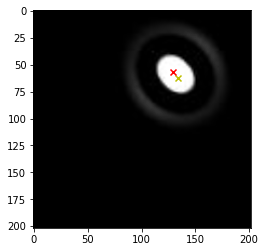

72.3 77.6


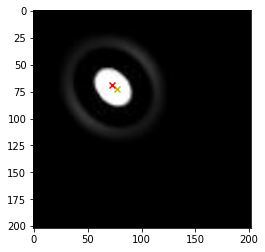

125.5 91.0


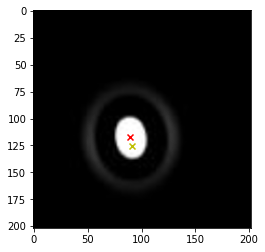

144.33333333333334 101.83333333333333


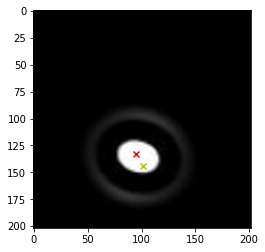

145.5 111.0


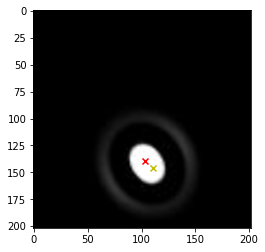

116.0 60.0


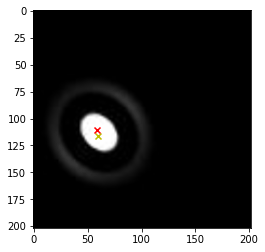

92.10714285714286 144.25


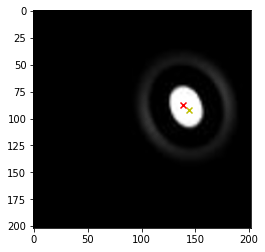

132.4 89.0


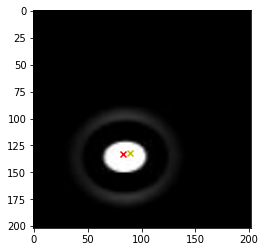

60.0 97.0


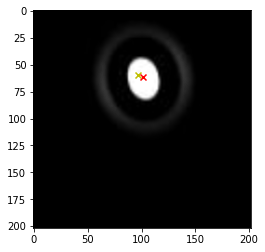

91.0 106.5


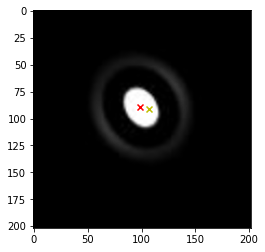

140.0 103.0


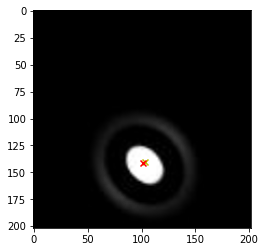

89.0 92.66666666666667


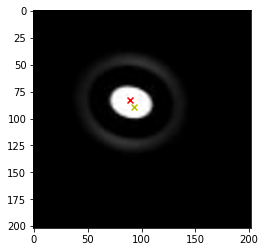

118.33333333333333 93.0


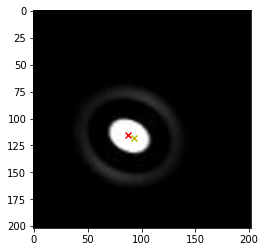

68.11111111111111 82.88888888888889


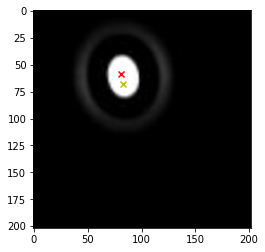

81.3157894736842 110.26315789473684


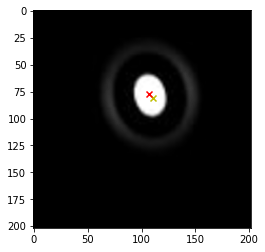

126.0 140.42857142857142


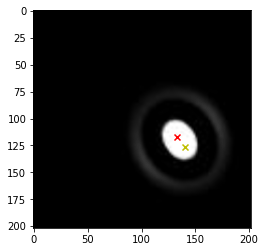

125.5 94.0


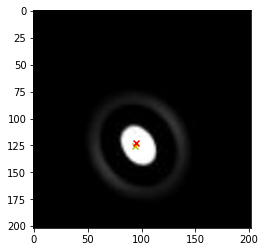

113.5 123.0


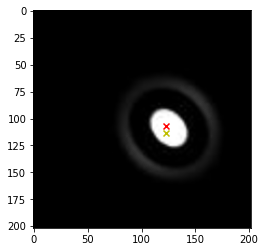

107.0 91.0


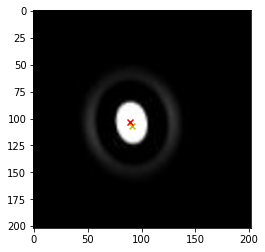

128.0 129.0


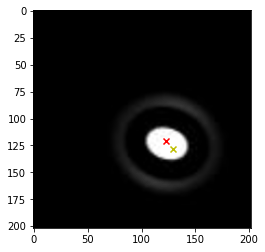

80.0 91.0


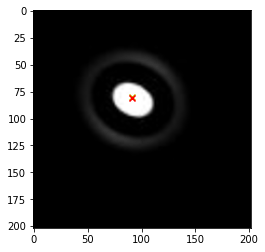

95.0 123.0


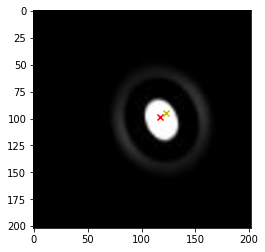

91.0 106.5


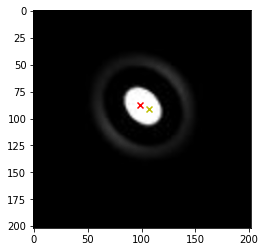

87.73076923076923 85.61538461538461


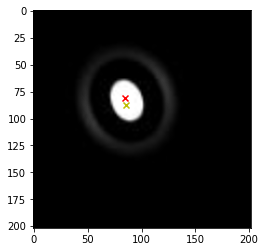

92.45 89.95


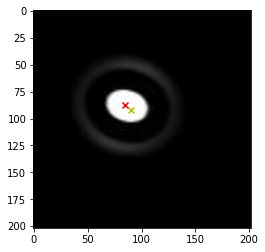

65.0 138.0


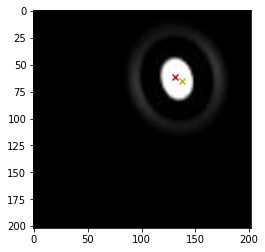

69.21428571428571 69.78571428571429


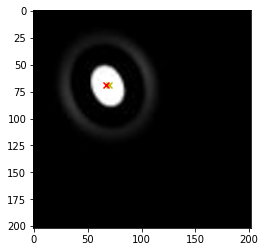

94.16666666666667 144.33333333333334


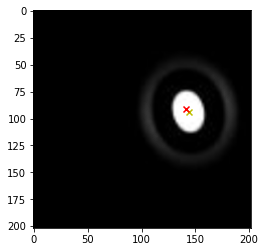

89.55555555555556 64.66666666666667


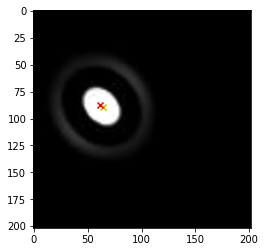

76.19354838709677 134.09677419354838


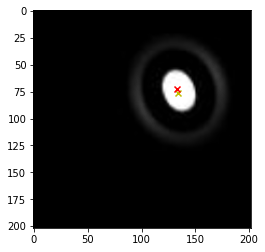

93.91666666666667 73.58333333333333


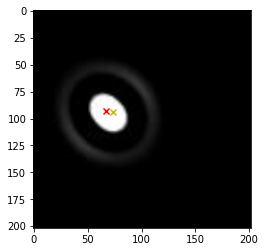

97.0 123.0


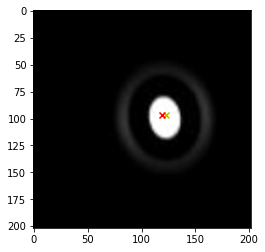

69.0 67.0


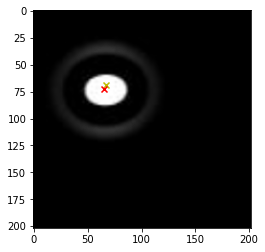

74.82352941176471 67.0


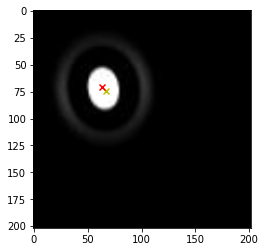

108.0 123.0


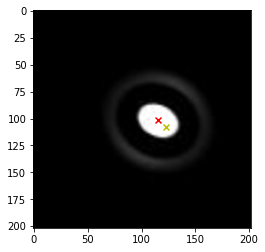

113.0 60.0


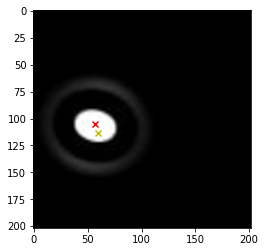

132.65 75.25


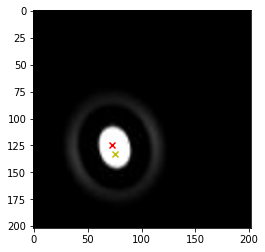

123.0 97.0


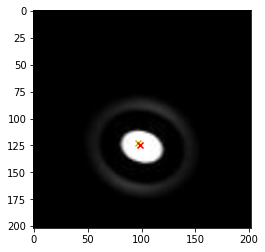

118.84615384615384 68.48717948717949


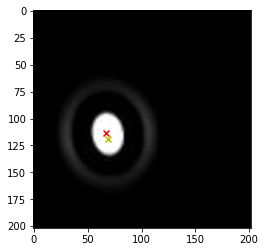

81.0 143.0


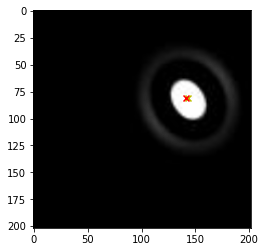

142.0 94.0


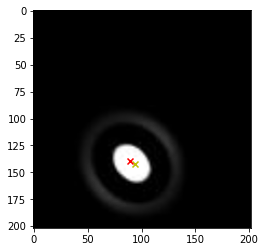

110.0 95.33333333333333


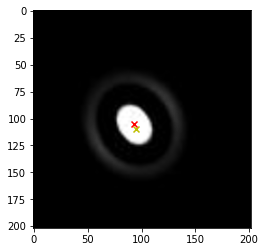

91.33333333333333 143.92592592592592


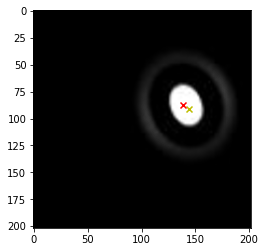

97.0 123.0


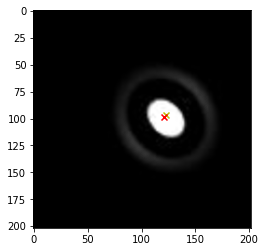

135.47540983606558 116.62295081967213


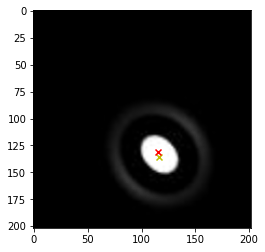

81.2 71.6


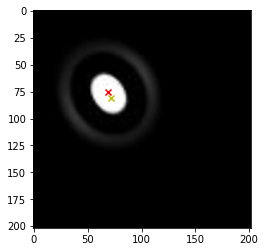

116.0 60.0


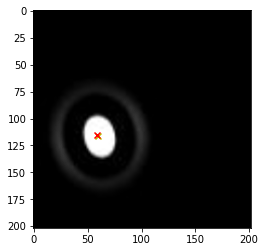

97.0 58.0


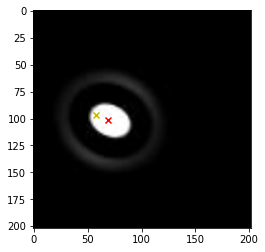

70.0 109.0


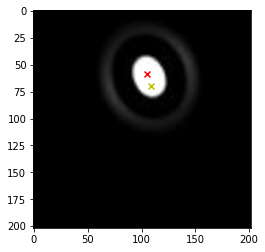

104.0 143.0


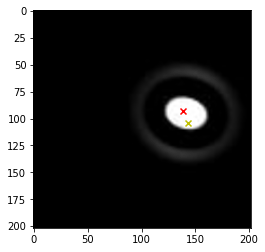

63.0 91.0


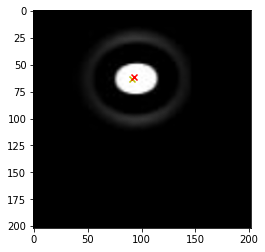

79.73333333333333 110.13333333333334


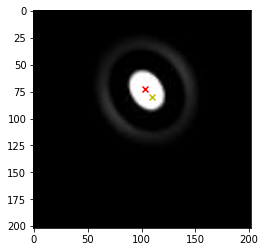

90.72727272727273 87.95454545454545


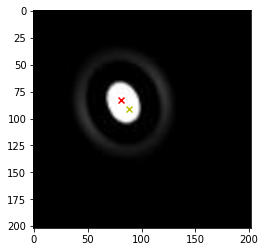

128.0 129.0


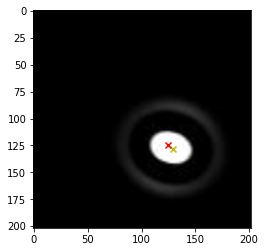

123.0 133.0


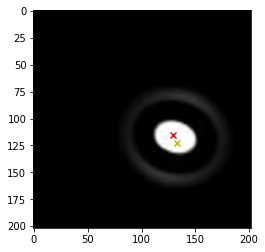

113.5 123.0


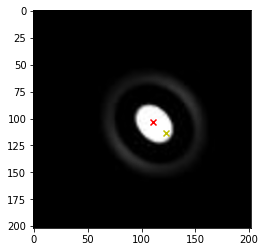

108.5 91.0


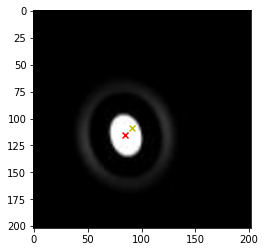

123.5 123.5


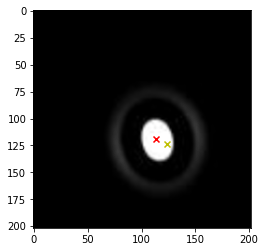

133.76923076923077 73.87179487179488


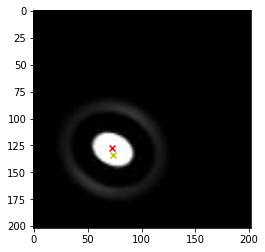

116.33333333333333 92.0


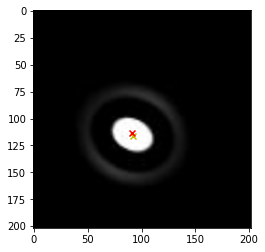

128.0 123.0


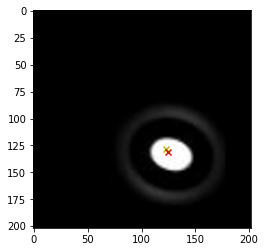

119.15384615384616 125.23076923076923


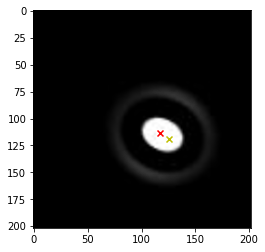

124.0 73.0


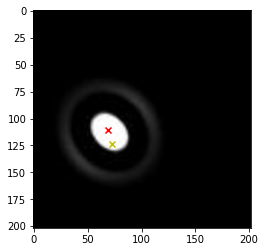

63.5 123.0


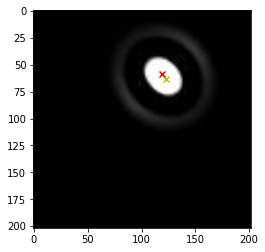

91.0 131.0


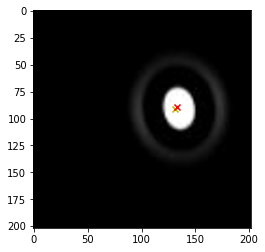

81.75 72.125


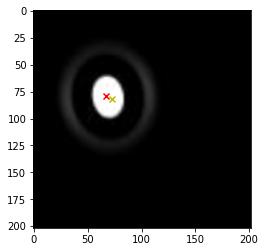

89.85 80.55


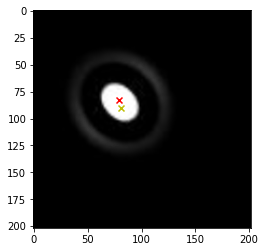

59.9375 65.375


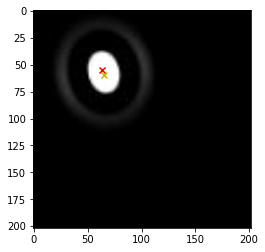

113.0 104.0


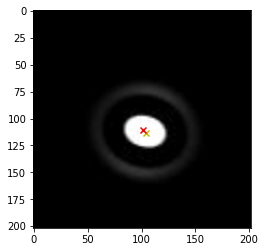

107.0 91.0


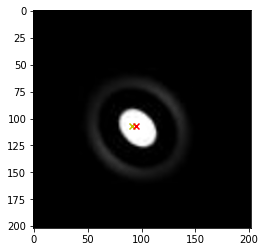

99.24 109.88


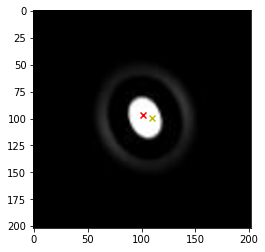

121.28571428571429 75.57142857142857


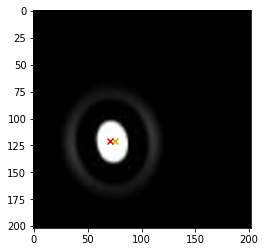

78.25 125.5


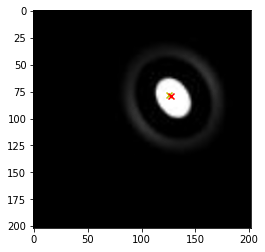

68.08333333333333 65.33333333333333


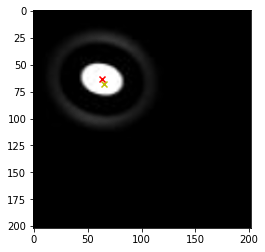

124.66666666666667 93.0


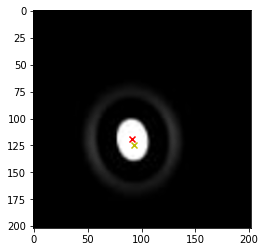

70.0 109.0


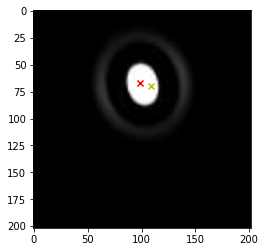

60.0 97.0


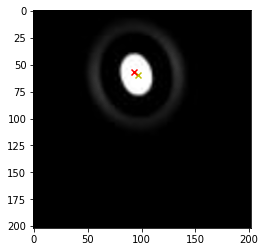

108.8695652173913 74.08695652173913


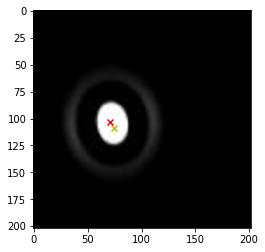

128.0 91.0


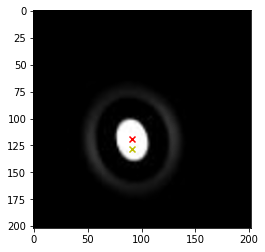

113.0 104.0


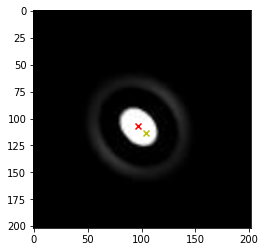

70.0 109.0


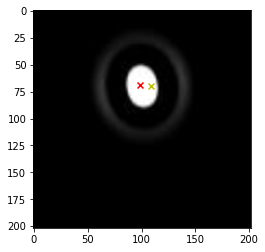

143.0 60.0


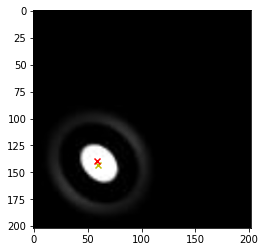

132.55223880597015 115.05970149253731


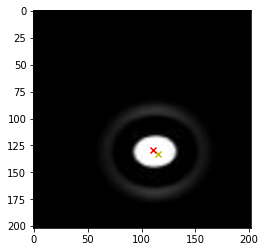

91.0 131.0


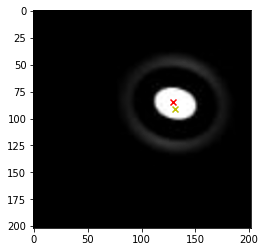

91.4 120.2


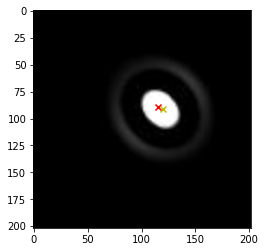

91.0 109.0


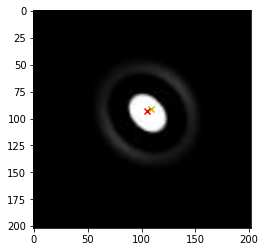

97.0 123.0


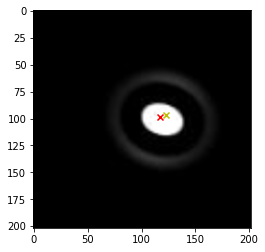

129.4 123.4


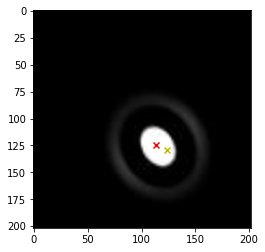

72.54545454545455 80.72727272727273


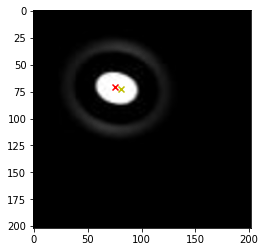

85.0 124.0


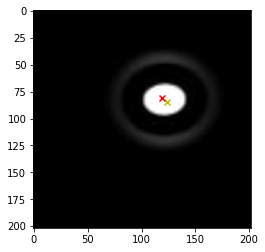

133.0 61.0


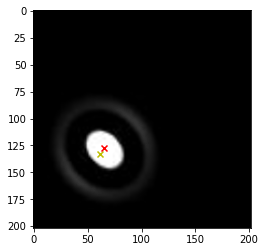

112.51923076923077 114.65384615384616


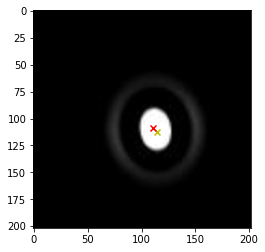

128.0 129.0


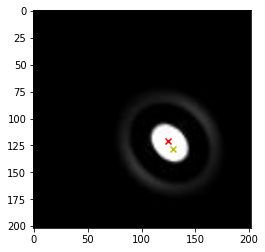

67.0 123.0


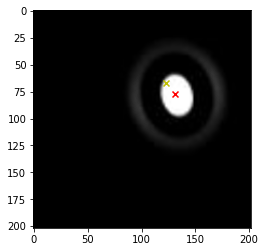

91.0 104.0


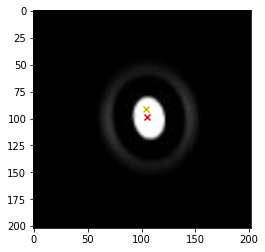

91.0 106.5


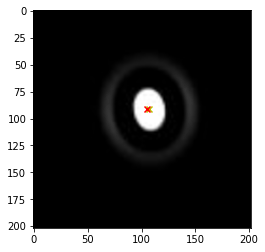

82.63636363636364 116.27272727272727


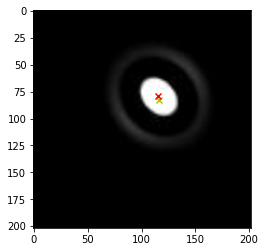

135.63888888888889 84.0


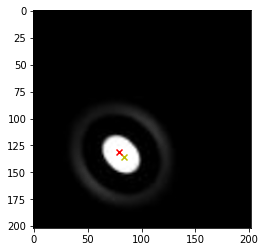

125.5 68.25


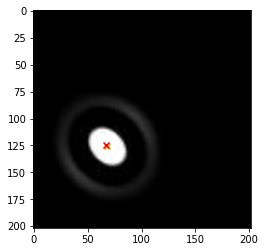

76.0 70.0


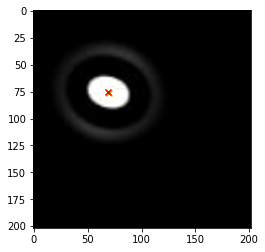

60.0 91.0


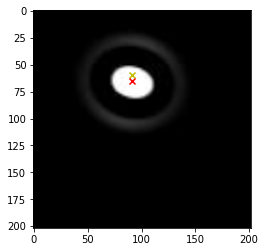

73.85714285714286 122.14285714285714


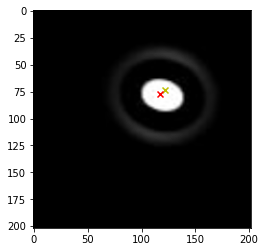

144.33333333333334 127.33333333333333


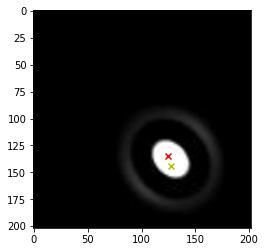

136.0 105.66666666666667


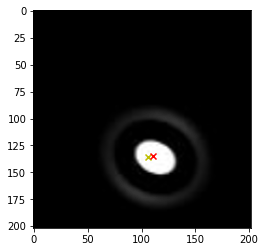

148.0 143.0


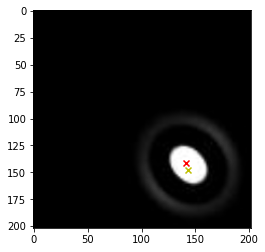

94.8 94.05


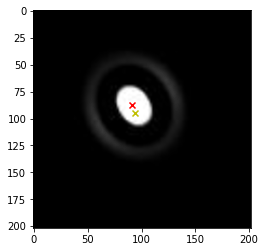

114.8 141.2


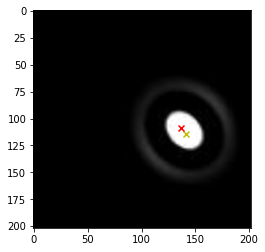

123.0 91.0


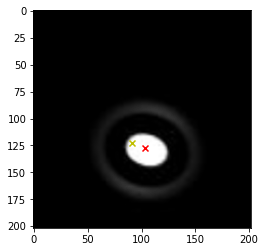

118.0 100.5


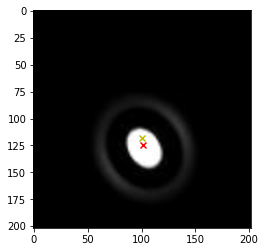

109.0 91.0


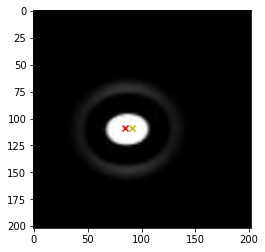

Not close x 120
Not close y 131


In [19]:
# calculate x-y accuracy based on image (not NN)

from scipy.interpolate import interp2d
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

index = 0
x_count, y_count = 0, 0
x_predicted = []
y_predicted = []

for index in range(0, 200):
# grid = [[1,2,3], [4,5,6], [7,8,9]]
    grid = X_test[index]
    interpolate_amount = 2

    mymin,mymax = np.min(grid), np.max(grid)
    X = np.linspace(mymin, mymax, len(grid))
    Y = np.linspace(mymin, mymax, len(grid))

    x,y = np.meshgrid(X,Y, sparse=True)
    grid = np.array(grid)

    new_grid = interp2d(x, y, grid, kind='linear')

    Xnew = np.linspace(mymin, mymax,len(grid) * interpolate_amount)
    Ynew = np.linspace(mymin, mymax,len(grid) * interpolate_amount)

    new_grid = new_grid(Xnew, Ynew)

    result = np.where(new_grid == np.amax(new_grid))
    print(np.mean(result[0]), np.mean(result[1]))
    result_0 = np.mean(result[0])
    x_predicted.append(result_0 / 2)
    result_1 = np.mean(result[1])
    y_predicted.append(result_1 / 2)
    
    plt.scatter(result_1, result_0, c="y", marker="x") # 1-indexed, compensate with -1
    plt.scatter(test_y_labels[index] * 2, test_x_labels[index] * 2, c="r", marker="x") # 1-indexed, compensate with -1
    
    close_x = (abs(result_0 - test_x_labels[index] * 2) <= COORD_EPSILON * 3)
    close_y = (abs(result_1 - test_y_labels[index] * 2) <= COORD_EPSILON * 3)

    close = close_x and close_y
    if not close_x:
        x_count += 1
    if not close_y:
        y_count += 1

        
    # print(new_grid)
    plt.imshow(np.squeeze(new_grid), cmap='gray')
    plt.show()
#     plt.imshow(np.squeeze(grid), cmap='gray')
#     plt.show()

print("Not close x", y_count)
print("Not close y", x_count)

In [20]:
print(COORD_EPSILON)

1.0


In [39]:
import matplotlib.animation as animation
import os
import subprocess
import glob 

Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

# for index in range(0, len(X_test)):
#     plt.scatter(y_predicted[index], x_predicted[index], c="r", marker="x")
#     plt.scatter(test_y_labels[index], test_x_labels[index], c="y", marker="x")
#     plt.imshow(np.squeeze(X_test[index]), cmap='gray')
#     plt.savefig("/Users/zhimin/Courtney/winter_research/images/file%03d.png" % index)
#     plt.clf()


os.chdir("/Users/zhimin/Courtney/winter_research/images")
subprocess.call([
    'ffmpeg', '-framerate', '1', '-i', 'file%03d.png', '-r', '30', '-pix_fmt', 'yuv420p',
    'video_name.mp4'
])
# for file_name in glob.glob("*.png"):
#     os.remove(file_name)

0

In [ ]:
def plot_history(history, ylim=70): # Thank you catkins
    """
    Plot train and validation accuracy and loss in one chart.
    :param history: The dictionary containing the accuracy and loss history.
    """
    keep = ""
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title('Loss and Accuracy of Train vs Validation data')
    for key, value in history.history.items():
        ax.plot(value, label=key)
        print(f'Final {key}: {round(value[-1], 3)}')
        if key == "accuracy":
            keep = value
    plt.ylim([0,ylim])
    ax.legend()
    plt.show()
    return keep
# val = plot_history(x_history)

# val = plot_history(y_history)

val = plot_history(angle_history)